In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [278]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
#import healpy as hp
import numpy as np


from tools import *
from tools import _trans
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os, scipy, sys

import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [293]:
sindec_bins = np.linspace(-1,1,100)
sindec_mids = (sindec_bins[1:]+sindec_bins[:-1])/2.
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

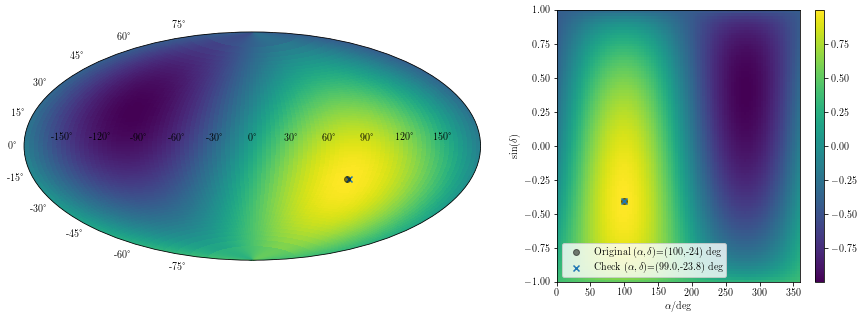

In [325]:
# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(*np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
             )

ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
xx,yy=np.meshgrid(np.rad2deg(ra_bins), sindec_bins)
im = ax2.pcolormesh(
    xx,yy,
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30, use_gridspec=True)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)

fig.savefig('plots/CR_dipole.png',dpi=200, bbox_inches='tight')

# Now we want to test if we can also see this dipole in neutrinos and if we can distinguish this from a uniform distribution

Define a llh ratio test based on a poisson pdf
$\mathcal{L} = \prod_i \frac{(\lambda^i_b+\lambda^i_s)^{k_i}}{k_i!} e^{-(\lambda^i_b+\lambda^i_s)}$ 

where i runs over all bins. 
* The background hypothesis is that we have atmospheric background $\lambda_b$ and a uniform astrophysical part $\lambda_s(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi^{uni}_0(\alpha, \sin(\delta)) \left(\frac{E}{E_0}\right)^{-\gamma} dE$, where $\phi^{uni}_0(\alpha, \sin(\delta))=\phi_0$ 
* For the signal hypotheis on the other we assume that the astrophysical flux can be described a uniform component and a non_uniform part connected to the CR dipole, yielding $\phi^{dip}_0(\alpha, \sin(\delta)) = \phi_0^* (1-A_d) + \phi_0^* A_d \phi_d(\alpha, \sin(\delta))$, where $A_d$ is the dipole amplitude and $\phi_d(\alpha, \sin(\delta))$ the dipole shape

# The test statistic function

$\Lambda = 2\log \frac{\max_{\theta in H_s}\mathcal{L}(\theta|D)}{\max_{\theta in H_b}\mathcal{L}(\theta|D)}= 2 \sum_i k_i \log\left( \frac{\lambda_b+\lambda^{dip}_s}{\lambda_b+\lambda^{uni}_s}\right) - \lambda^{dip}_s + \lambda^{uni}_s$ 

the sum runs over all bins (we will use a binning in ra, sin(dec) and maybe energy)

* $\lambda_s^{uni}(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi_0 \left(\frac{E}{E_0}\right)^{-\gamma} dE$  

* $\lambda_s^{dip}(\alpha, \sin(\delta)) = \int  A_{\mathrm{eff}}(\sin(\delta), E) \phi^{dip}_0(\alpha, \sin(\delta)) \left(\frac{E}{E_0}\right)^{-\gamma} dE $

* $\lambda_b$: background expectation from MCEq

# Get the background expectations in each bin

In [6]:
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm

In [7]:
#config.e_min = 1#86e-3
#config.e_max = 1e9#1e11
#config.debug_level = 2
#config.enable_em = False
#config.mkl_threads = 32
#config.hybrid_crossover = 0.5

In [8]:
base_model = 'SIBYLL23C'
mceq = MCEqRun(
    interaction_model=base_model,
    theta_deg=0.,
    #primary_model= (pm.HillasGaisser2012, "H3a"),
    primary_model=(pm.GlobalSplineFitBeta,
             '/Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2')
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


In [9]:
mag = 0


#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(0.5,0,3))*180./np.pi

flux_def = dict()
#Initialize empty grid
for frac in ['numu_conv','numu_pr','numu_total',
             'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = np.zeros_like(mceq.e_grid)

    
#Sum fluxes, calculated for different angles
for theta in angles:
    mceq.set_theta_deg(theta)
    mceq.solve()
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['mu_conv'] += (mceq.get_solution('conv_mu+', mag)
                         + mceq.get_solution('conv_mu-', mag))

    flux_def['mu_pr'] += (mceq.get_solution('pr_mu+', mag)
                       + mceq.get_solution('pr_mu-', mag))

    flux_def['mu_total'] += (mceq.get_solution('total_mu+', mag)
                          + mceq.get_solution('total_mu-', mag))
    
    
    # same meaning of prefixes for muon neutrinos as for muons
    flux_def['numu_conv'] += (mceq.get_solution('conv_numu', mag)
                         + mceq.get_solution('conv_antinumu', mag))

    flux_def['numu_pr'] += (mceq.get_solution('pr_numu', mag)
                       + mceq.get_solution('pr_antinumu', mag))

    flux_def['numu_total'] += (mceq.get_solution('total_numu', mag)
                          + mceq.get_solution('total_antinumu', mag))

    # same meaning of prefixes for electron neutrinos as for muons
    flux_def['nue_conv'] += (mceq.get_solution('conv_nue', mag)
                        + mceq.get_solution('conv_antinue', mag))

    flux_def['nue_pr'] += (mceq.get_solution('pr_nue', mag)
                      + mceq.get_solution('pr_antinue', mag))

    flux_def['nue_total'] += (mceq.get_solution('total_nue', mag)
                         + mceq.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux_def['nutau_pr'] += (mceq.get_solution('total_nutau', mag)
                        + mceq.get_solution('total_antinutau', mag))

#average the results
for frac in [
             'numu_conv','numu_pr','numu_total',
            'mu_conv','mu_pr','mu_total',
             'nue_conv','nue_pr','nue_total','nutau_pr']:
    flux_def[frac] = flux_def[frac]/float(len(angles))

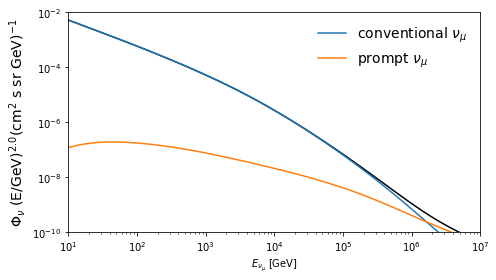

In [10]:
fig, ax = plt.subplots( figsize=(7,4))
e_grid = mceq.e_grid

fs=14
spec = 2.
for i,(pref, lab) in enumerate([('numu_',r'\nu_\mu')]):
    
    p0 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'total'], color='k', ls='solid', lw=1.5)
    p1 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'conv'],  ls='solid', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    p2 = ax.loglog(e_grid, e_grid**(spec)*flux_def[pref + 'pr'], ls='solid', lw=1.5, 
               label='prompt ${0}$'.format(lab))
    
    
    
    ax.set_xlim(10,1e7)
    
    ax.set_ylim(1e-10,1e-2)
    #ax.set_ylim(0.8,1.2)
    ax.set_xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    
    ax.legend(loc='upper right',frameon=False,numpoints=1,fontsize=fs)

ax.set_ylabel(r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + 
           "(cm$^{2}$ s sr GeV)$^{-1}$", fontsize=fs)
    
    

fig.tight_layout()

# Now use the effective areas that i created for plenum to get signal and background event number descriptions

In [102]:
path = 'resources/'
results = np.load(os.path.join(path, 'effective_areas_av_per_day_fine_binning.npy'))

etrue_bins = np.arange(2,8.1,0.1) # np.linspace(2.,9.,num=25)
etrue_mids = 10**((etrue_bins[1:]+etrue_bins[:-1])/2.)
etrue_bins = 10**etrue_bins

sd_bins = np.linspace(-1.,1.,35)
n_sd, n_e = len(sd_bins)-1, len(etrue_bins)-1

etrue_bin_width = np.diff(etrue_bins)

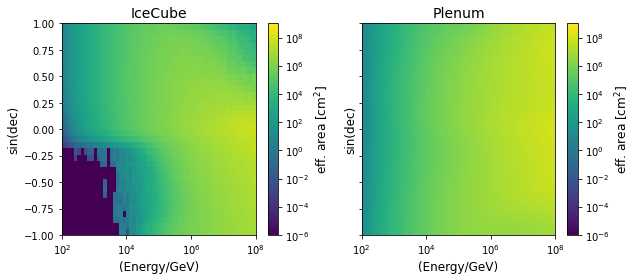

In [103]:
fig, axes=plt.subplots(ncols=2, figsize=(9,4), sharey=True)
effA_splines = dict()

ax = axes[0]
ax.set_title('IceCube', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins, #Res_effA*1e4
                  results['effA_icecube'].reshape((n_sd, n_e)) 
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)

binmids = ( get_mids(sd_bins, ext=True), etrue_mids)
#print(etrue_mids.shape, sd_bins.shape, np.log(results['effA_icecube'].reshape((n_sd, n_e))).shape)
effA_spline_ice = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(results['effA_icecube'].reshape((n_sd, n_e))),
                    method="linear",
                    bounds_error=False,
                    fill_value=-10.
                    )

effA_splines['icecube'] = effA_spline_ice


ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)
ax.set_xscale('log')

ax = axes[1]
ax.set_title('Plenum', fontsize=14)
p = ax.pcolormesh(etrue_bins, sd_bins,
                  results['effA_plenum'].reshape((n_sd, n_e))  
                  , norm=LogNorm(),#, vmin=1e-2)#, 
                  vmax = 1e9, vmin=1e-6)
effA_spline_plenum = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(results['effA_plenum'].reshape((n_sd, n_e))),
                    method="linear",
                    bounds_error=False,
                    fill_value=-10.
                    )
effA_splines['plenum'] = effA_spline_plenum

ax.set_xlabel(r'(Energy/GeV)',fontsize=12)
ax.set_ylabel(r'sin(dec)',fontsize=12)

cb=fig.colorbar(p,ax=ax)
cb.set_label(r'eff. area [cm$^2$]', fontsize=12)


ax.set_xscale('log')
fig.tight_layout()

# Get also the public energy smearing function 

In [104]:
ereco_bins = np.arange(2,7.1,0.2) # np.linspace(2.,9.,num=25)
ereco_mids = 10**get_mids(ereco_bins)
ereco_bins = 10**ereco_bins

n_ereco = len(ereco_mids)

In [105]:
d_public_2021_smearing = np.genfromtxt('/Users/mhuber/Downloads/icecube_10year_ps/irfs/IC86_II_smearing.csv',
                        skip_header=1)

In [106]:
log_emin_smearing, log_emax_smearing = d_public_2021_smearing[:,0], d_public_2021_smearing[:,1]
log_emids_smearing = (log_emin_smearing+log_emax_smearing)/2.
sdec_min_smearing, sdec_mac_smearing = (np.sin(np.deg2rad(d_public_2021_smearing[:,2])), 
                      np.sin(np.deg2rad(d_public_2021_smearing[:,3])))

log_erec_min_smearing, log_erec_max_smearing = d_public_2021_smearing[:,4], d_public_2021_smearing[:,5]
log_erec_mids_smearing = (log_erec_min_smearing+log_erec_max_smearing)/2.

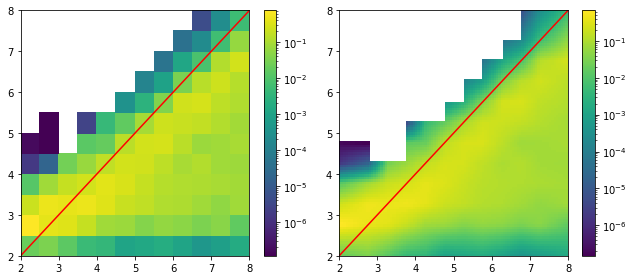

In [107]:
fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(9,4))
counts = d_public_2021_smearing[:,-1]



    
    
bins = (np.arange(2,8.1,0.5), np.arange(2,8.1,0.5))
h,_,_= np.histogram2d(log_emids_smearing,log_erec_mids_smearing, 
          bins=bins, weights=counts)

h = h / h.sum(axis=1)[:,np.newaxis]


binmids = tuple([get_mids(bi, ext=True) for bi in bins])
smearing_spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

ax = axes[0]
p=ax.pcolormesh(bins[0], bins[1], h.T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

ax = axes[1]
grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')

p=ax.pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
ax.plot([2,8], [2,8], color='red')
cb=fig.colorbar(p,ax=ax)

    
fig.tight_layout()

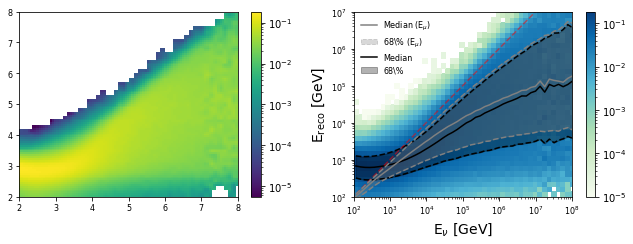

In [108]:
fs_ticks=12
sys.path.append('/Users/mhuber/Python_Tools/')
from my_functions import weighted_median
idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
k_mc = 'muon_energy_entry'
mask = np.isnan(idata[k_mc])
idata = idata[~mask]


bins_reco = np.linspace(2, 8.1, 45)
mids_reco = 10**get_mids(bins_reco)
bins_reco = 10**bins_reco



fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9,3.5), squeeze=True) 
ax = axes[1]

k_mc = 'trueE'
k_reco = 'energy'
bins_mc = np.linspace(2, 8.2, 50)
mids_mc = 10**get_mids(bins_mc)
bins_mc = 10**bins_mc


gamma=2.
w = np.ones_like(idata['ow'])# * idata['trueE']**(-gamma)# np.ones_like(idata[k_mc])
h,_,_ = np.histogram2d(idata[k_mc], idata[k_reco], bins = (bins_mc, bins_reco), weights=w)
# normalize along the mc axis to get P(E_reco| E_entry)
norm = h.sum(axis=1)
norm[norm==0] = 1.
h /= norm[:,np.newaxis]

binmids = tuple([get_mids(bi, ext=True) for bi in (np.log10(bins_mc), np.log10(bins_reco))])
smearing_spline = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(h),
                    method="linear",
                    bounds_error=False,
                    fill_value=0.
                    )

grid_etrue = np.linspace(bins[0][0], bins[0][-1],100) 
grid_ereco = np.linspace(bins[1][0], bins[1][-1],100) 

xx,yy = np.meshgrid(grid_etrue, grid_ereco,indexing='ij')
p=axes[0].pcolormesh(grid_etrue, grid_ereco, np.exp(smearing_spline((xx, yy))).T, norm=LogNorm())
fig.colorbar(p, ax=axes[0])


med_low,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata[k_reco], w, 0.5)


p = ax.pcolormesh( bins_mc, bins_reco, h.T, norm=LogNorm(), cmap='GnBu', vmin=1e-5, vmax=h.max())
cb = fig.colorbar(p, ax=ax)
#cb.set_label(r'P(E$_{\mathrm{reco}}$ $|$ E$_{\nu}$)', fontsize=fs)

c = 'black'
ax.plot(mids_mc, med50, color=c, label=r'Median')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3,  label=r'68\%')

ax.plot([1,1e7],[1,1e7], ls='dashed', color='red', alpha=0.5)

# also show the actual deviation between muon (entry) and neutrino energy
med_low,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, (1-0.68)/2.)
med_up,_  = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 1-(1-0.68)/2.)
med50,_ = weighted_median(bins_mc, idata[k_mc], idata['muon_energy_entry'], w, 0.5)

c = 'grey'
ax.plot(mids_mc, med50, color=c, label=r'Median (E$_{\mu}$)')
ax.plot(mids_mc, med_low, ls='dashed', color=c)
ax.plot(mids_mc, med_up, ls='dashed', color=c)
ax.fill_between(mids_mc, med_low,med_up, color=c, alpha=0.3, linestyle='dashed', label=r'68\% (E$_{\mu}$)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e8)
ax.set_ylim(1e2, 1e7)
ax.set_xlabel(r'E$_{\nu}$ [GeV]', fontsize=fs)
ax.set_ylabel(r'E$_{\mathrm{reco}}$ [GeV]', fontsize=fs)


handles, labels = ax.get_legend_handles_labels()
hmu68 = handles.pop(-1)
h68 = handles.pop(-1)
hmu = handles.pop(-1)
h = handles.pop(-1)
handles.append(hmu)
handles.append(hmu68)
handles.append(h)
handles.append(h68)

ax.legend(handles=handles, frameon=False, loc='upper left', fontsize=fs-6)
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=fs_ticks-4)

fig.tight_layout()

# Now get the background expectations 

In [18]:
from copy import copy

In [295]:
pixel_sizes = ra_width*sindec_width[:,np.newaxis] 
lt = 10*365.25*86400

# use integrated values over energy, but set some lower energy threshold here
# since we will receive data in reco energy bins only this energy makes sense here
_eval = 1e1
em_ind = np.argmin(np.abs(np.log10(ereco_mids) - np.log10(_eval)))
print(em_ind)

0


In [296]:
Res_mu = dict()
Res_numu = dict()
Res_mu_prompt = dict()
Res_numu_prompt = dict()

Res_mu_reco = dict()
Res_numu_reco = dict()
Res_mu_prompt_reco = dict()
Res_numu_prompt_reco = dict()


tck_numu = splrep(mceq.e_grid, np.log(flux_def['numu_conv'])  , s=1.e-2)
tck_numu_pr = splrep(mceq.e_grid, np.log(flux_def['numu_pr'])  , s=1.e-2)

tck_mu = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_conv'])[:-1]  , s=1.e-2)
tck_mu_pr = splrep(mceq.e_grid[:-1], np.log(flux_def['mu_pr'])[:-1]  , s=1.e-2)

for exp in ['icecube', 'plenum']:
    
    n_sindec = len(sindec_mids)
    NTOT_numu = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_mu = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_numu_prompt = np.zeros((n_e,n_sindec), dtype=float)
    NTOT_mu_prompt = np.zeros((n_e,n_sindec), dtype=float)

    NTOT_numu_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_mu_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_numu_prompt_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    NTOT_mu_prompt_reco = np.zeros((n_ereco,n_sindec), dtype=float)
    
    effA = effA_splines[exp]

    for i, sd_i in enumerate(sindec_mids):
        for k,ei in enumerate(etrue_mids):

            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_numu))  * etrue_bin_width[k]) 
            
            # flux_def['numu_conv'][ind_mceq][k]
            NTOT_numu[k,i] = Ni
            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_numu_pr)) * etrue_bin_width[k])
            #flux_def['numu_pr'][ind_mceq][k] 
            NTOT_numu_prompt[k,i] = Ni

            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_mu)) * etrue_bin_width[k])
            
            #flux_def['mu_conv'][ind_mceq][k]
            NTOT_mu[k,i] = Ni
            
            Ni = np.sum(np.exp(effA((sd_i, ei))) * np.exp(splev(ei, tck_mu_pr)) * etrue_bin_width[k])
            #flux_def['mu_pr'][ind_mceq][k] 
            NTOT_mu_prompt[k,i] = Ni
        
        # Now also get the event rates in reco energy bins
        xx,yy = np.meshgrid(np.log10(etrue_mids), np.log10(ereco_mids), indexing='ij')
        smearing = np.exp(smearing_spline((xx,yy)))
        smearing = smearing / smearing.sum(axis=1)[:,np.newaxis]
    
    
        NTOT_numu_reco[:,i] = np.dot(smearing.T, NTOT_numu[:,i])
        NTOT_mu_reco[:,i] = np.dot(smearing.T, NTOT_mu[:,i])
        NTOT_numu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_numu_prompt[:,i])
        NTOT_mu_prompt_reco[:,i] = np.dot(smearing.T, NTOT_mu_prompt[:,i])
        
    
    # Now also add the right ascension axes and integrate over the pixel size
    # to get the actual number of events in that bin
    Res_mu_reco[exp] = (NTOT_mu_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...]
    Res_numu_reco[exp] = (NTOT_numu_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...]
    Res_mu_prompt_reco[exp] = (NTOT_mu_prompt_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...]
    Res_numu_prompt_reco[exp] = (NTOT_numu_prompt_reco[...,np.newaxis]*pixel_sizes*lt)[em_ind:,...]

In [50]:
304702934 / lt 

0.9655453329784267

# Now also get signal expectation values for different phi0, gamma, A_d values

In [298]:
phi100s = 10**np.linspace(-23,-16, 10)
gammas = np.arange(1.5,4.1,0.5)
A_dipole = np.linspace(0,0.3,10)

In [266]:
def int_powerlaw(gamma, emin, emax, E0=1e5):
    if gamma!=1:
        return E0**(gamma)*1./(1-gamma) * (emax**(1-gamma) - emin**(1-gamma))

    else:
        return E0**(gamma)*np.log(emax/emin)

In [299]:
F = dict()
for exp in ['icecube', 'plenum']:
    
    xx,yy = np.meshgrid(sindec_mids,etrue_mids,indexing='ij')
    _effa = np.exp(effA_splines[exp]((xx,yy)))
    fexp =np.zeros((n_ereco, n_sindec, len(ra_mids) ,
                        len(phi100s), len(gammas), len(A_dipole)),
                       dtype=float)

    for k, phi100i in enumerate(phi100s):
        for l0, gamma_l0 in enumerate(gammas):
            for m, ad in enumerate(A_dipole):
                f = np.array([int_powerlaw(gamma_l0, etrue_bins[j], etrue_bins[j+1]) 
                                            for j,ej in enumerate(etrue_mids)])
                f2 = f*_effa
                e_part = np.dot(smearing.T, f2.T)[...,np.newaxis]*pixel_sizes*lt
                phi_part = phi100i *((1-ad) + ad*dipole.T)
                fexp[...,k,l0,m] = e_part * phi_part
                
    F[exp] = fexp[em_ind:,...]
    print('{0} done!'.format(exp))

icecube done!
plenum done!


4.641588833612791e-19 2.0 0.06666666666666667
vals 449.6449835591786
icecube 1375.0699041580347


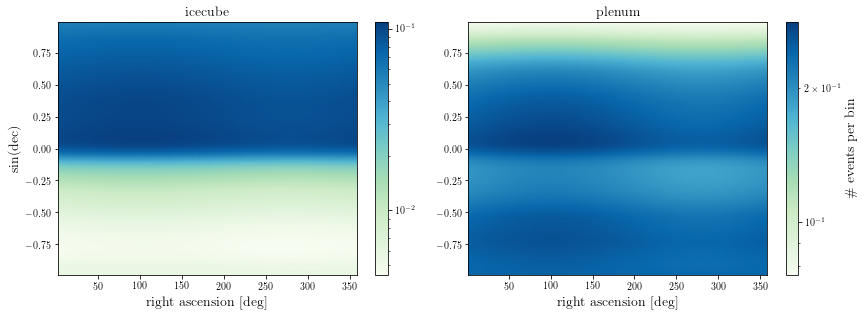

In [326]:
ind_dip = 2

fig, axes = plt.subplots(ncols=2, figsize=(12,4.5))


print(phi100s[6], gammas[1], A_dipole[ind_dip])
vals = F['icecube'][...,6,1,4].T
print('vals', np.sum(vals))



for i, exp in enumerate(['icecube', 'plenum']):
    ax = axes[i]
    ax.set_title(exp, fontsize=fs)
    p = ax.pcolormesh( np.degrees(ra_mids), sindec_mids, np.sum(F[exp][...,6,1,ind_dip], axis=0), 
                      cmap='GnBu', norm=LogNorm(), shading='gouraud')
    cb=fig.colorbar(p, ax=ax)
    if exp=='plenum':
        cb.set_label('\# events per bin ',fontsize=fs)
    ax.set_xlabel('right ascension [deg]',fontsize=fs)

fig.tight_layout()
axes[0].set_ylabel('sin(dec)',fontsize=fs)

fig.savefig('plots/Dipole2dDist_Neutrinos_a{0:.2f}.png'.format(A_dipole[ind_dip]),
               bbox_inches="tight", dpi=200)

idata = np.load('/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')
w = (idata['astro'])*lt 
print('icecube', np.sum(w))

4.641588833612791e-19 2.0 0.16666666666666666


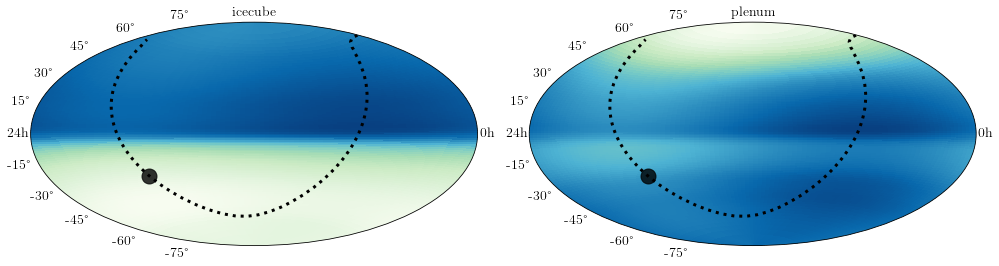

In [324]:
ind_dip = 5

fig =  plt.figure(figsize=(14, 6.))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0], projection="hammer")
ax2 = fig.add_subplot(spec[1], projection="hammer")

axes= [ax, ax2]
for i, exp in enumerate(['icecube', 'plenum']):
    ax = axes[i]
    ax.set_title(exp, fontsize=fs)
    _ra,_dec = _trans(ra_bins,np.arcsin(sindec_bins))
    p = ax.pcolormesh( _ra,_dec, np.sum(F[exp][...,6,1,ind_dip], axis=0), 
                      cmap='GnBu', norm=LogNorm())
                      
    #fig.colorbar(p, ax=ax)
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs)


    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------

    add_plane(ax, color='black')


    
    
fig.tight_layout()
fig.savefig('plots/DipoleSkymap_Neutrinos_a{0:.2f}.png'.format(A_dipole[ind_dip]),
               bbox_inches="tight", dpi=200)
print(phi100s[6], gammas[1], A_dipole[ind_dip])

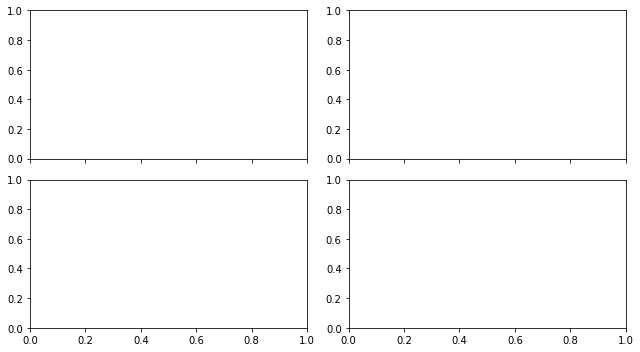

In [115]:
import scipy
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9,5), sharex=True)

Signal_Splines = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    F_template = copy(F[exp])
    F_template[F_template==0] = 1e-15

    binmids = (ereco_mids, sindec_mids, ra_mids, phi100s, gammas, A_dipole)
    spline_sig = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    bounds_error=False,
                    fill_value=1e-15,
                    )

    Signal_Splines[exp] = spline_sig
    '''
    ax = axes[k,0]
                   
    p = ax.pcolormesh(phi100s, gammas, F_template[3,5,...,0].T, norm=LogNorm(), cmap='GnBu' )
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')

    ax = axes[k,1]
    _phis = 10**np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
    _gs = np.linspace(np.min(gammas), np.max(gammas), 25)
    xx, yy = np.meshgrid(_phis, _gs, indexing='ij')
    spline_res = np.exp(spline_sig((sindec_mids[3], ra_mids[5], xx,yy, A_dipole[0]  )))


    p = ax.pcolormesh(_phis, _gs, spline_res.T, norm=LogNorm())
    cb=fig.colorbar(p,ax=ax)
    ax.set_xscale('log')
    '''
fig.tight_layout()

# Generate a function that allows to generate radndom trials 

In [116]:
XX,YY,ZZ = np.meshgrid(ereco_mids, sindec_mids, ra_mids, indexing='ij')
def conv_func_signal(log10_phi100, gamma, a_dipole, spline):
    _phi100 = 10**np.atleast_1d(log10_phi100)
    gamma = np.atleast_1d(gamma)
    a_dipole = np.atleast_1d(a_dipole)
    
    #print(_phi100, gamma,a_dipole)
    res = np.exp(spline((XX.flatten(),YY.flatten(),ZZ.flatten(),
                          _phi100[:,np.newaxis], gamma[:,np.newaxis], 
                          a_dipole[:,np.newaxis] )))
    
    #res = np.exp(spline((XX.flatten(),YY.flatten(),
    #                      _phi100, gamma, 
    #                      a_dipole )))
    #print('here',res.shape)
    return res.reshape((len(_phi100),)+XX.shape)

In [124]:
rand = np.random.RandomState(0)
def generate_bckg_data(lambda_b, n_trials, med=False):
    if med:
        return lambda_b
    out = rand.poisson(lambda_b.flatten(), size=(n_trials, len(lambda_b.flatten())))
    return out.reshape((n_trials,)+lambda_b.shape)

def generate_signal_data(log10_phi100, gamma, a_dipole, n_trials, spline, med=False):
    lambda_s = conv_func_signal(log10_phi100, gamma, a_dipole, spline)[0]
    if med:
        return lambda_s
    out = rand.poisson(lambda_s.flatten(), size=(n_trials, len(lambda_s.flatten())))
    return out.reshape((n_trials,)+lambda_s.shape)

# Now define the test statistic function

In [128]:
def LambdaTS(log10_phi100, gamma, a_dipole, data, lambda_b, spline):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    lambda_s = conv_func_signal(log10_phi100, gamma, a_dipole, spline)
    #print(np.all(lambda_s[0]==lambda_s[1]))
    #print(lambda_s.shape, lambda_b.shape)
    r = lambda_s / lambda_b #background expectation should not be 0    
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    #_mask = lambda_b == 0
    r[_mask] = 0
    #print((np.log(1+r) * data).shape)
    res = 2 * np.sum(np.log(1+r) * data - lambda_s, axis=(1,2,3))
    #print(res)
    return res

In [118]:
# Now start with a simple llh scan of one expectation
phi_exp = 1.44e-18
gamma_exp = 2.28
a_dip_exp = 0.2

lambda_bckg = Res_numu_reco['plenum']
lambda_sig = conv_func_signal(np.log10(phi_exp), gamma_exp, a_dip_exp, Signal_Splines['plenum'])
d_tot = lambda_bckg+lambda_sig[0]
print(d_tot.shape)

(25, 49, 50)


In [91]:
LambdaTS([np.log10(phi_exp)]*2, 2*[gamma_exp], 2*[a_dip_exp], d_tot, lambda_bckg, 
                          spline=Signal_Splines['plenum'])

(2, 50, 99, 100)


array([336.8294819, 336.8294819])

In [ ]:


_log_phis = np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 20 )
_gs = np.linspace(np.min(gammas), np.max(gammas), 15)
_adips = np.linspace(A_dipole[0], A_dipole[-1], 10)

xx,yy,zz= np.meshgrid(_log_phis, _gs, _adips, indexing='ij')

#ts_vals = np.zeros_like(xx.flatten(), dtype=float)
#print(len(ts_vals))
Lambda_best = LambdaTS(np.log10(phi_exp), gamma_exp, a_dip_exp,d_tot, lambda_bckg, 
                          spline=Signal_Splines['plenum'])
print('lb', Lambda_best)
        
ts_vals = (LambdaTS(xx.flatten(), yy.flatten(), zz.flatten(), d_tot, lambda_bckg, 
                          spline=Signal_Splines['plenum'])
                  - Lambda_best)
    
ts_vals = ts_vals.reshape(xx.shape)     

# Now we can plot this outcome 

In [ ]:
fig, ax = plt.subplots()


p=ax.pcolormesh(xx[:,6,:],zz[:,6,:], -ts_vals[:,6,:], cmap='GnBu', norm=LogNorm())
ax.scatter(np.log10(phi_exp), a_dip_exp, marker='o')

fig.colorbar(p,ax=ax)

In [78]:
_log_phis = np.linspace(np.log10(np.min(phi100s)), np.log10(np.max(phi100s)), 50 )
_gs = np.linspace(np.min(gammas), np.max(gammas), 15)


xx,yy= np.meshgrid(_log_phis, _gs, indexing='ij')

#ts_vals = np.zeros_like(xx.flatten(), dtype=float)
#print(len(ts_vals))
Lambda_best = LambdaTS(np.log10(phi_exp), gamma_exp, a_dip_exp,d_tot, lambda_bckg, 
                          spline=Signal_Splines['plenum'])
print('lb', Lambda_best)
        
ts_vals = (LambdaTS(xx.flatten(), yy.flatten(), a_dip_exp, d_tot, lambda_bckg, 
                          spline=Signal_Splines['plenum'])
                  - Lambda_best)
    
ts_vals = ts_vals.reshape(xx.shape)     

lb [50.35901953]


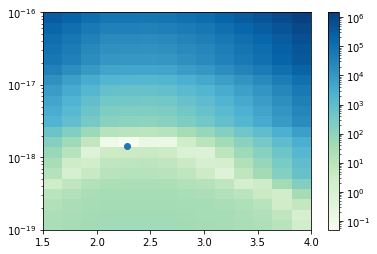

In [79]:
fig, ax = plt.subplots()


p=ax.pcolormesh(yy, 10**xx, -ts_vals, cmap='GnBu', norm=LogNorm())
ax.scatter( gamma_exp, phi_exp, marker='o')

ax.set_yscale('log')

ax.set_ylim(1e-19,1e-16)
fig.colorbar(p,ax=ax)

# Now only do a scan in A_dipole

In [121]:
_adips = np.linspace(A_dipole[0], A_dipole[-1], 15)

TS_1d = dict() 
for exp in ['icecube', 'plenum']:
    
    ts_vals_1d = np.zeros_like(_adips, dtype=float)
    if exp == 'icecube':
        continue
    Lambda_best = LambdaTS(np.log10(phi_exp), gamma_exp, a_dip_exp,d_tot, lambda_bckg, 
                              spline=Signal_Splines[exp])
    print('lb', Lambda_best)
    '''
    for i, zi in enumerate(_adips):

        
        ts_vals_1d[i] = (LambdaTS(np.log10(phi_exp), gamma_exp, zi, d_tot, lambda_bckg, 
                              spline=Signal_Splines[exp])
                      - Lambda_best)
    '''
    ts_vals_1d = (LambdaTS(np.ones_like(_adips)*np.log10(phi_exp), np.ones_like(_adips)*gamma_exp, _adips, 
                           d_tot, lambda_bckg, 
                              spline=Signal_Splines[exp])
                      - Lambda_best)
    TS_1d[exp] = ts_vals_1d

(1, 25, 49, 50)
lb [263.31099352]
(15, 25, 49, 50)


(0.0, 0.3)

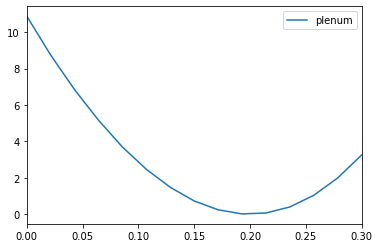

In [122]:
fig, ax = plt.subplots()

for exp in ['icecube', 'plenum']:
    if exp == 'icecube':
        continue
    ax.plot(_adips, -TS_1d[exp], label=exp)
    
#ax.axvline(a_dip_exp)
ax.legend()
#ax.set_ylim(0, 4)#np.max(-TS_1d['plenum']))
ax.set_xlim(0,0.3)

# Do a few background scans just to see how the distribution will look like

In [129]:
_adips = np.linspace(A_dipole[0], A_dipole[-1], 15)

Bckg_TS = dict() 
for exp in ['icecube', 'plenum']:
    
    ts_vals_1d = np.zeros_like(_adips, dtype=float)
    if exp == 'icecube':
        continue
    
   
    ntrials=10
    bckg_ts = np.zeros(ntrials)
    lambda_bckg = Res_numu_reco['plenum']
    d_tot = generate_bckg_data(lambda_bckg, n_trials=ntrials)
    d_tot += generate_signal_data(np.log10(phi_exp), gamma_exp, a_dipole=0, n_trials=ntrials, 
                         spline=Signal_Splines[exp])
    
    
    for i, d_toti in enumerate(d_tot):
        Lambda_best = LambdaTS(np.log10(phi_exp), gamma_exp, 0, d_toti, lambda_bckg, 
                              spline=Signal_Splines[exp])
        print('lb', Lambda_best)
        
        ts_vals_1d = (LambdaTS(np.ones_like(_adips)*np.log10(phi_exp), np.ones_like(_adips)*gamma_exp, _adips, 
                           d_toti, lambda_bckg, 
                              spline=Signal_Splines[exp])
                          - Lambda_best)
        
        bckg_ts[i] = np.max(ts_vals_1d)
        print('ts', bckg_ts[i], _adips[np.argmax(ts_vals_1d)])
        
    Bckg_TS[exp] = bckg_ts

lb [361.57090767]
ts 0.0 0.0
lb [347.22760916]
ts 0.0 0.0
lb [400.07746914]
ts 0.0 0.0
lb [417.04217072]
ts 0.0 0.0
lb [344.94651203]
ts 1.303454286720239 0.06428571428571428
lb [331.14768382]
ts 0.30250684663582206 0.04285714285714286
lb [365.69657254]
ts 0.0 0.0
lb [325.85740524]
ts 0.061687540193247514 0.02142857142857143
lb [285.40663224]
ts 0.7167256934441752 0.04285714285714286
lb [278.06502293]
ts 0.07924818932229982 0.02142857142857143


(array([7., 0., 1., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.        , 0.13034543, 0.26069086, 0.39103629, 0.52138171,
        0.65172714, 0.78207257, 0.912418  , 1.04276343, 1.17310886,
        1.30345429]),
 <BarContainer object of 10 artists>)

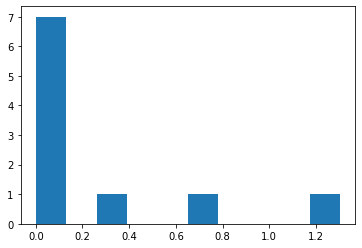

In [130]:
fig, ax = plt.subplots()

ax.hist(Bckg_TS['plenum'], bins=10)

# Now fix the flux normalisation and the spectral index for a second to reproduce lisa's results

In [203]:
phi100_1d = [1.44e-18]
gammas_1d = [2.28]
A_dipole_1d = np.linspace(0,0.3,30)

In [204]:
F_1d = dict()
for exp in ['icecube', 'plenum']:
    
    xx,yy = np.meshgrid(sindec_mids,etrue_mids,indexing='ij')
    _effa = np.exp(effA_splines[exp]((xx,yy)))
    fexp =np.zeros((n_ereco, n_sindec, len(ra_mids) ,
                        len(A_dipole)),
                       dtype=float)

    for k, phi100i in enumerate(phi100_1d):
        for l0, gamma_l0 in enumerate(gammas_1d):
            for m, ad in enumerate(A_dipole):
                f = np.array([int_powerlaw(gamma_l0, etrue_bins[j], etrue_bins[j+1]) 
                                            for j,ej in enumerate(etrue_mids)])
                f2 = f*_effa
                e_part = np.dot(smearing.T, f2.T)[...,np.newaxis]*pixel_sizes*lt
                phi_part = phi100i *((1-ad) + ad*dipole.T)
                fexp[...,m] = e_part * phi_part
                
    F_1d[exp] = fexp[em_ind:,...]
    print('{0} done!'.format(exp))

icecube done!
plenum done!


In [205]:
import scipy

Signal_Splines_1d = dict()

for k, exp in enumerate(['icecube', 'plenum']):
    
    F_template = copy(F_1d[exp])
    F_template[F_template==0] = 1e-15

    binmids = (ereco_mids, sindec_mids, ra_mids, A_dipole_1d)
    spline_sig = scipy.interpolate.RegularGridInterpolator(
                    binmids, np.log(F_template),
                    method="linear",
                    bounds_error=False,
                    fill_value=-15,
                    )

    Signal_Splines_1d[exp] = spline_sig
    


In [206]:
XX,YY,ZZ = np.meshgrid(ereco_mids, sindec_mids, ra_mids, indexing='ij')
def conv_func_signal_1d(a_dipole, spline):
    a_dipole = np.atleast_1d(a_dipole)
    res = np.exp(spline((XX.flatten(),YY.flatten(),ZZ.flatten(),
                          a_dipole[:,np.newaxis] )))
   
    return res.reshape((len(a_dipole),)+XX.shape)

In [182]:
def generate_signal_data_1d(a_dipole, n_trials, spline, med=False):
    lambda_s = conv_func_signal_1d(a_dipole, spline)[0]
    if med:
        return lambda_s
    out = rand.poisson(lambda_s.flatten(), size=(n_trials, len(lambda_s.flatten())))
    return out.reshape((n_trials,)+lambda_s.shape)

In [183]:
def LambdaTS_1d(a_dipole, data, lambda_b, spline, lambda_s=None):
    r'''
    phi100: flux normalisation at 100TeV of the singal
    gamma: spectral index of the singal
    data: observed number of events in each energy bin
    lambda_b: expected number of background events in each bin
    '''
    
    if lambda_s is None:
        lambda_s = conv_func_signal_1d(a_dipole, spline)
    
    r = lambda_s / lambda_b #background expectation should not be 0    
    _mask = (np.ones_like(lambda_s)*lambda_b) == 0
    r[_mask] = 0
    
    res = 2 * np.sum(np.log(1+r) * data - lambda_s, axis=(1,2,3))
    return res

In [151]:
import time

In [229]:
_adips = np.linspace(A_dipole_1d[0], A_dipole_1d[-1], 35)

Bckg_TS = dict() 
for exp in ['icecube', 'plenum']:
    
    ts_vals_1d = np.zeros_like(_adips, dtype=float)
    
   
    ntrials=500
    bckg_ts = np.zeros(ntrials)
    lambda_bckg = Res_numu_reco[exp]
    d_tot = generate_bckg_data(lambda_bckg, n_trials=ntrials)
    d_tot += generate_signal_data_1d(a_dipole=0, n_trials=ntrials, 
                         spline=Signal_Splines_1d[exp])
    
    
    lambda_sig = conv_func_signal_1d(_adips, spline=Signal_Splines_1d[exp])
    lambda_sig0 = conv_func_signal_1d(0, spline=Signal_Splines_1d[exp])
    print('Start')
    start= time.clock()
    for i, d_toti in enumerate(d_tot):
        Lambda_best = LambdaTS_1d(0, d_toti, lambda_bckg, 
                              spline=Signal_Splines_1d[exp], lambda_s=lambda_sig0)
        
        
        ts_vals_1d = (LambdaTS_1d(_adips, 
                           d_toti, lambda_bckg, 
                              spline=Signal_Splines_1d[exp], lambda_s=lambda_sig)
                          - Lambda_best)
        
        bckg_ts[i] = np.max(ts_vals_1d)
        
    print('Done')
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            ntrials))
    Bckg_TS[exp] = bckg_ts

Start
Done
500 trials finished after   0h  0' 27.50''
Start
Done
500 trials finished after   0h  0' 26.93''


In [157]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.504
0.57


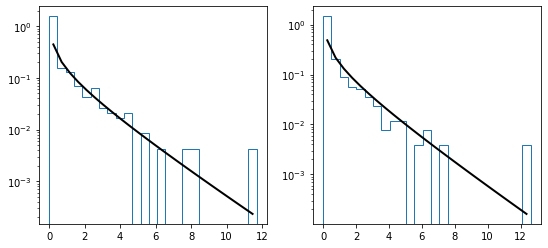

In [233]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

Bckg_fit = dict()
for k, exp in enumerate(['icecube', 'plenum']):
    ax = axes[k]
    p = ax.hist(Bckg_TS[exp], bins=25, histtype='step', density=True)

    hr = np.sum(Bckg_TS[exp]==0)/float(len(Bckg_TS[exp]))
    print(hr)

    xvals = get_mids(p[1])
    fit_func = delta_chi2(eta=hr, df=1.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                   )
    Bckg_fit[exp] = fit_func
    ax.set_yscale('log')

# Do scans with certain signal 

In [244]:
dipole_sigs = np.arange(0.01, 0.2, 0.02)
print(len(dipole_sigs))

10


In [247]:

_adips = np.linspace(A_dipole_1d[0], A_dipole_1d[-1], 65)
TS_SCANS = dict()
PVals = dict()
for exp in ['icecube', 'plenum']:
       
    p_vals = np.zeros_like(dipole_sigs,dtype=float)
    lambda_bckg = Res_numu_reco[exp]
    print('Start')
    TS_Scans = dict()
    start= time.clock()
    for k, dipole_sig in enumerate(dipole_sigs):
    
        d_tot = lambda_bckg + conv_func_signal_1d(dipole_sig, 
                                              Signal_Splines_1d[exp])[0]
    
    
        lambda_sig = conv_func_signal_1d(_adips, spline=Signal_Splines_1d[exp])
        lambda_sig0 = conv_func_signal_1d(dipole_sig, spline=Signal_Splines_1d[exp])
        
        



        Lambda_best = LambdaTS_1d(dipole_sig, d_tot, lambda_bckg, 
                                  spline=Signal_Splines_1d[exp], lambda_s=lambda_sig0)
        ts_scan = (LambdaTS_1d(_adips, 
                           d_tot, lambda_bckg, 
                              spline=Signal_Splines_1d[exp], lambda_s=lambda_sig)
                         -Lambda_best )

        TS_Scans[k] = -ts_scan
        print(dipole_sig, ts_scan[0])
        p_vals[k] = Bckg_fit[exp].sf(-ts_scan[0])
    
    TS_SCANS[exp] = TS_Scans
    PVals[exp] = p_vals
    print('Done')
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("Scan finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            ntrials))


Start
0.01 -0.03757455810875854
0.03 -0.3406221776657219
0.049999999999999996 -0.9532498035075321
0.06999999999999999 -1.8828141555859759
0.08999999999999998 -3.137323727989269
0.10999999999999997 -4.725551585542689
0.12999999999999998 -6.657179508489307
0.15 -8.942986245333174
0.16999999999999998 -11.595099878743156
0.18999999999999997 -14.62734714977438
Done
Scan finished after   0h  1' 11.11''
Start
0.01 -0.12105707779835484
0.03 -1.0976404680740188
0.049999999999999996 -3.072510009360485
0.06999999999999999 -6.070200271196313
0.08999999999999998 -10.11753616092193
0.10999999999999997 -15.244046057410173
0.12999999999999998 -21.482493480865344
0.15 -28.869576882792217
0.16999999999999998 -37.4468760585828
0.18999999999999997 -47.262175617767355
Done
Scan finished after   0h  1' 10.19''


0.0609375
4.441884029249081


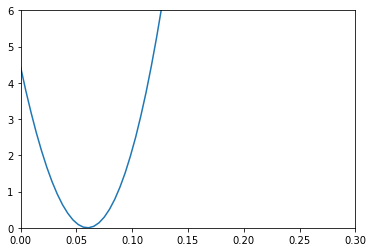

In [216]:
fig, ax = plt.subplots()

ax.plot(_adips, -ts_scan)
print(_adips[np.argmin(-ts_scan)])
ax.set_ylim(0,6)
ax.set_xlim(0,0.3)
print(-ts_scan[0])

In [237]:
from scipy.stats import norm 
def sigma2pval(sigma, one_sided=True):
    if one_sided:
        return norm.sf(sigma)
    else: 
        return 1.-(norm.cdf(sigma)-norm.cdf(-sigma))

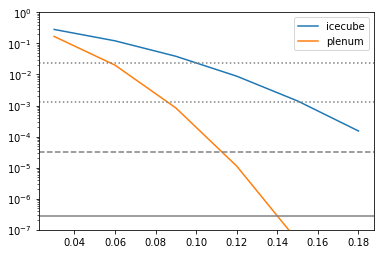

In [238]:
fig,ax = plt.subplots()

for exp in ['icecube', 'plenum']:
    ax.plot(dipole_sigs, PVals[exp], label=exp)
    
ax.axhline(sigma2pval(2), color='grey', ls='dotted')
ax.axhline(sigma2pval(3), color='grey', ls='dotted')
ax.axhline(sigma2pval(4), color='grey', ls='dashed')
ax.axhline(sigma2pval(5), color='grey', ls='solid')
    
ax.set_ylim(1e-7,1)
ax.legend()
ax.set_yscale('log')


In [241]:
dipole_sig = dipole_sigs[5]
print(dipole_sig)

0.060000000000000005


In [259]:
_adips = np.linspace(A_dipole_1d[0], A_dipole_1d[-1], 35)

Sig_TS = dict() 
for exp in ['icecube', 'plenum']:
    
    res = np.zeros((len(dipole_sigs), ) ,dtype=[('med', float), 
                                               ('sigma_low',float), ('sigma_high', float)])
    for k, dipole_sig in enumerate(dipole_sigs):
        print('Start')
        start= time.clock()
        
        
        ts_vals_1d = np.zeros_like(_adips, dtype=float)

        ntrials=500
        sig_ts = np.zeros(ntrials)
        lambda_bckg = Res_numu_reco[exp]
        d_tot = generate_bckg_data(lambda_bckg, n_trials=ntrials)
        d_tot += generate_signal_data_1d(a_dipole=dipole_sig, n_trials=ntrials, 
                             spline=Signal_Splines_1d[exp])


        lambda_sig = conv_func_signal_1d(_adips, spline=Signal_Splines_1d[exp])
        lambda_sig0 = conv_func_signal_1d(0, spline=Signal_Splines_1d[exp])
        
        for i, d_toti in enumerate(d_tot):
            Lambda_best = LambdaTS_1d(dipole_sig, d_toti, lambda_bckg, 
                                  spline=Signal_Splines_1d[exp], lambda_s=lambda_sig0)


            ts_vals_1d = (LambdaTS_1d(_adips, 
                               d_toti, lambda_bckg, 
                                  spline=Signal_Splines_1d[exp], lambda_s=lambda_sig)
                              - Lambda_best)

            sig_ts[i] = np.max(ts_vals_1d)

            
       
        print('Done')
        stop = time.clock()
        mins, secs = divmod(stop-start,60)
        hours,mins = divmod(mins,60)
        print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                             ntrials))
        res['med'][k] = np.median(sig_ts)
        res['sigma_low'][k] = np.percentile(sig_ts, (100-68.)/2.)
        res['sigma_high'][k] = np.percentile(sig_ts, 100-(100-68.)/2.)
    
    Sig_TS[exp] = res

Start
Done
500 trials finished after   0h  0' 30.83''
Start
Done
500 trials finished after   0h  0' 29.47''
Start
Done
500 trials finished after   0h  0' 29.56''
Start
Done
500 trials finished after   0h  0' 29.45''
Start
Done
500 trials finished after   0h  0' 29.32''
Start
Done
500 trials finished after   0h  0' 29.55''
Start
Done
500 trials finished after   0h  0' 29.36''
Start
Done
500 trials finished after   0h  0' 29.52''
Start
Done
500 trials finished after   0h  0' 29.42''
Start
Done
500 trials finished after   0h  0' 29.42''
Start
Done
500 trials finished after   0h  0' 30.23''
Start
Done
500 trials finished after   0h  0' 30.10''
Start
Done
500 trials finished after   0h  0' 30.07''
Start
Done
500 trials finished after   0h  0' 30.11''
Start
Done
500 trials finished after   0h  0' 30.06''
Start
Done
500 trials finished after   0h  0' 30.02''
Start
Done
500 trials finished after   0h  0' 30.08''
Start
Done
500 trials finished after   0h  0' 30.14''
Start
Done
500 trials finish

In [260]:
print(Sig_TS['icecube']['med'])

[1.14480699e-02 3.01799397e-01 1.01547314e+00 1.96058360e+00
 3.11651055e+00 5.14248262e+00 6.11557084e+00 8.83577057e+00
 1.14933409e+01 1.45611043e+01]


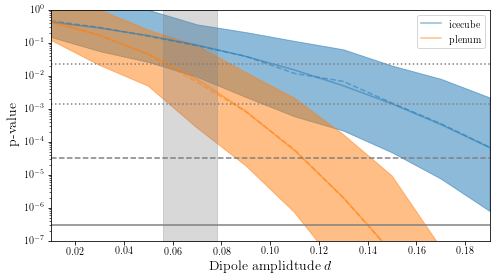

In [322]:
fig,ax = plt.subplots(figsize=(7,4))

for exp in ['icecube', 'plenum']:
    p=ax.plot(dipole_sigs, PVals[exp], label=exp,alpha=0.5)
    ax.plot(dipole_sigs, Bckg_fit[exp].sf(Sig_TS[exp]['med']), color=p[0].get_color(),
           ls='dashed',alpha=0.5)
    ax.fill_between(dipole_sigs, Bckg_fit[exp].sf(Sig_TS[exp]['sigma_low']),
                   Bckg_fit[exp].sf(Sig_TS[exp]['sigma_high']), alpha=0.5,
                   color=p[0].get_color(),)
    
    
ax.axhline(sigma2pval(2), color='grey', ls='dotted')
ax.axhline(sigma2pval(3), color='grey', ls='dotted')
ax.axhline(sigma2pval(4), color='grey', ls='dashed')
ax.axhline(sigma2pval(5), color='grey', ls='solid')
    
ax.set_ylim(1e-7,1)
ax.legend()
ax.set_yscale('log')
ax.set_xlim(dipole_sigs[0], dipole_sigs[-1])

y= 10**np.linspace(-7,0,10)
ax.fill_betweenx(y, (0.065-0.009)*np.ones_like(y), (0.065+0.013)*np.ones_like(y), 
                 alpha=0.3, color='grey')


ax.set_xlabel('Dipole amplidtude $d$', fontsize=fs)
ax.set_ylabel('p-value', fontsize=fs)

fig.tight_layout()
fig.savefig('plots/DipoleAnalysis_pvalue_dist.pdf',
               bbox_inches="tight", dpi=200)

4.555798706948963


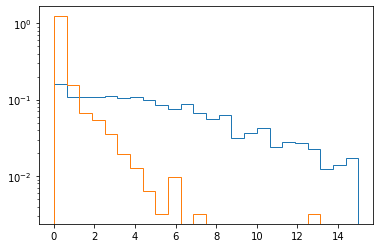

In [243]:
fig, ax = plt.subplots()

bins = np.linspace(0,15,25)
p = ax.hist(Sig_TS['plenum'], bins=bins, histtype='step', density=True)
print(np.median(Sig_TS['plenum']))
ax.hist(Bckg_TS['plenum'], bins=bins, histtype='step', density=True)
ax.set_yscale('log')

In [181]:
_adips = np.linspace(A_dipole_1d[0], A_dipole_1d[-1], 35)

Bckg_TS = dict() 
for exp in ['icecube', 'plenum']:
    
    ts_vals_1d = np.zeros_like(_adips, dtype=float)
    if exp == 'icecube':
        continue
    
   
    ntrials=500
    bckg_ts = np.zeros(ntrials)
    lambda_bckg = Res_numu_reco['plenum']
    d_tot = generate_bckg_data_1d(lambda_bckg, n_trials=ntrials)[np.newaxis,...]
    d_tot += generate_signal_data_1d(a_dipole=0, n_trials=ntrials, 
                         spline=Signal_Splines_1d[exp])
    
    
    lambda_sig = conv_func_signal_1d(_adips, spline=Signal_Splines_1d[exp])
    lambda_sig0 = conv_func_signal_1d(0, spline=Signal_Splines_1d[exp])
    print('Start')
    start= time.clock()
    
    
    ts_vals_1d = LambdaTS_1d(_adips, 
                           d_tot, lambda_bckg, 
                              spline=Signal_Splines_1d[exp], lambda_s=lambda_sig)
                          
        
        
    
    print('Done')
    stop = time.clock()
    mins, secs = divmod(stop-start,60)
    hours,mins = divmod(mins,60)
    print("{3} trials finished after {0:3d}h {1:2d}' {2:4.2f}''".format(int(hours),int(mins),secs, 
                                                                            ntrials))

Start
Done
500 trials finished after   0h  0' 29.95''


In [160]:
fit_func.sf(10)

0.0007827011290012745

In [ ]:
res = conv_func_signal([-19.], [2.1],[0.1], spline=Signal_Splines['plenum']
                      )

In [ ]:
res.shape

In [ ]:
fexp.shape

In [ ]:
lambda_b = Res_numu_reco['plenum']#.flatten()

generate_bckg_data(lambda_b, 2).shape

In [ ]:
lambda_b = np.ones(50000)
generate_bckg_data(lambda_b, 2)

In [ ]:
print(Res_numu_reco['icecube'].shape)

In [ ]:
print(np.max(Res_numu_reco['icecube'].flatten()))

In [ ]:
r = Res_numu_reco['icecube'].flatten()
r.dtype

In [ ]:
lambda_b.dtype